# Anomaly Detection Challenge

This notebook experiments with different anomaly detection algorithms on the HEP dataset.
We'll compare Isolation Forest and Flow Matching approaches.

In [40]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score, roc_curve, auc, accuracy_score
import time

# Import fAD components
from fad.data.loaders import _load_h5_challenge_dataset
from fad.data.preprocessing import Preprocessor, StandardScalerFunction, TSNEFunction
from fad.models.statistical import IsolationForestDetector 
from fad.models.flow_matching import FlowMatchingAnomalyDetector

## 1. Data Loading and Exploration

In [33]:
# Set paths to dataset files
path_bkg = "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/background_for_training.h5"
path_anom = "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/Ato4l_lepFilter_13TeV_filtered.h5"

# Load challenge datasets
print("Loading datasets...")
dataset = _load_h5_challenge_dataset(path_bkg, path_anom)

# Print dataset information
print(f"Training set shape: {dataset.train.shape}")
print(f"Test set shape: {dataset.test.shape}")
print(f"Number of anomalies in test set: {np.sum(dataset.test_labels)}")

Loading datasets...
Training set shape: (70000, 76)
Test set shape: (60000, 76)
Number of anomalies in test set: 30000.0


## 2. Data Preprocessing

In [ ]:
# Preprocess data with standardization
print("Preprocessing data...")
preprocessor = Preprocessor([StandardScalerFunction()])
X_train = preprocessor.transform(dataset.train, fit=True)
X_test = preprocessor.transform(dataset.test)
print("Done")

Preprocessing data...


## 3. t-SNE Visualization

t-SNE reduces dimensionality while preserving local structure, helping us visualize high-dimensional data.

Visualizing data with t-SNE (this may take a while)...


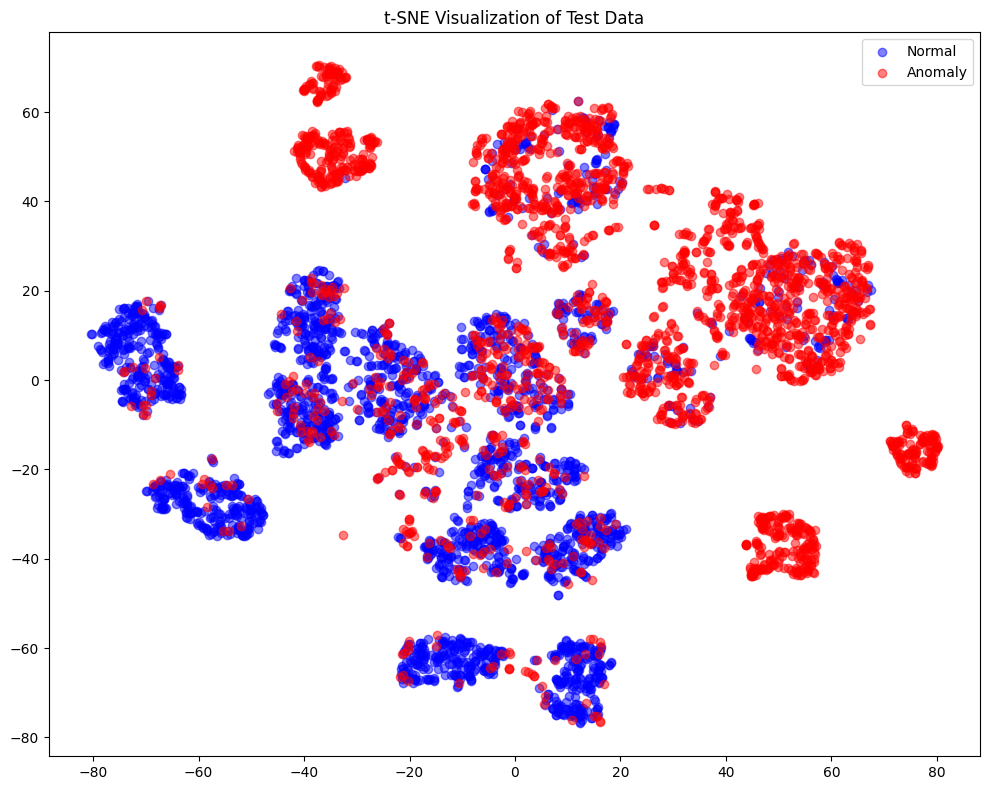

In [35]:
# Visualize data with t-SNE (subsample for speed)
print("Visualizing data with t-SNE (this may take a while)...")
subsample_size = min(5000, len(X_test))
indices = np.random.choice(len(X_test), subsample_size, replace=False)

tsne_preprocessor = Preprocessor([TSNEFunction(n_components=2)])
X_test_tsne = tsne_preprocessor.transform(X_test[indices], fit=True)
y_test_tsne = dataset.test_labels[indices]

# Plot t-SNE visualization
plt.figure(figsize=(10, 8))
plt.scatter(X_test_tsne[y_test_tsne == 0, 0], X_test_tsne[y_test_tsne == 0, 1], 
            c='blue', alpha=0.5, label='Normal')
plt.scatter(X_test_tsne[y_test_tsne == 1, 0], X_test_tsne[y_test_tsne == 1, 1], 
            c='red', alpha=0.5, label='Anomaly')
plt.title('t-SNE Visualization of Test Data')
plt.legend()
plt.tight_layout()
plt.show()

## 4. Train and Evaluate Models

We'll train and evaluate two models:
1. Isolation Forest (traditional algorithm)
2. Flow Matching (advanced generative model)

In [36]:
# Dictionary to store results
results = {}

### 4.1 Isolation Forest

In [43]:
print("Training Isolation Forest...")
start_time = time.time()
iso_forest = IsolationForestDetector(contamination=0.01)
iso_forest.fit(X_train)
iso_time = time.time() - start_time
print(f"Training time: {iso_time:.2f} seconds")

# Predict anomaly scores
iso_scores = iso_forest.predict(X_test)
iso_auc = roc_auc_score(dataset.test_labels, iso_scores)
iso_ap = average_precision_score(dataset.test_labels, iso_scores)
iso_accuracy = accuracy_score(dataset.test_labels, iso_scores < 0)
print(f"Accuracy: {iso_accuracy:.4f}")
print(f"AUC-ROC: {iso_auc:.4f}")
print(f"Average Precision: {iso_ap:.4f}")

results['Isolation Forest'] = {
    'scores': iso_scores,
    'auc': iso_auc,
    'ap': iso_ap,
    'time': iso_time
}

Training Isolation Forest...
Training time: 0.36 seconds
Accuracy: 0.4344
AUC-ROC: 0.8755
Average Precision: 0.8617


### 4.2 Flow Matching

In [ ]:
print("Training Flow Matching (this may take a while)...")
start_time = time.time()
flow_matching = FlowMatchingAnomalyDetector(
    input_dim=X_train.shape[1],
    hidden_dim=128,
    batch_size=256,
    iterations=300,  # Adjust based on your needs
    print_every=50,
    lr=0.001
)
flow_matching.fit(X_train)
flow_time = time.time() - start_time
print(f"Training time: {flow_time:.2f} seconds")

# Predict anomaly scores
flow_scores, _ = flow_matching.predict(X_test)
# print mean and std of scores for normal and anomalous samples
print(f"Mean score for normal samples: {np.mean(flow_scores[dataset.test_labels == 0]):.4f}")
print(f"Std score for normal samples: {np.std(flow_scores[dataset.test_labels == 0]):.4f}")
print(f"Mean score for anomalous samples: {np.mean(flow_scores[dataset.test_labels == 1]):.4f}")    
print(f"Std score for anomalous samples: {np.std(flow_scores[dataset.test_labels == 1]):.4f}")
flow_auc = roc_auc_score(dataset.test_labels, flow_scores)
flow_ap = average_precision_score(dataset.test_labels, flow_scores)
flow_accuracy = accuracy_score(dataset.test_labels, flow_scores>150)
print(f"Accuracy: {flow_accuracy:.4f}")
print(f"AUC-ROC: {flow_auc:.4f}")
print(f"Average Precision: {flow_ap:.4f}")

results['Flow Matching'] = {
    'scores': flow_scores,
    'auc': flow_auc,
    'ap': flow_ap,
    'time': flow_time
}

Training Flow Matching (this may take a while)...
| iter     50 |  3.92 ms/step | loss    2.100 
| iter    100 |  1.96 ms/step | loss    1.403 
| iter    150 |  1.71 ms/step | loss    1.916 
| iter    200 |  1.75 ms/step | loss    1.350 
| iter    250 |  1.96 ms/step | loss    1.561 
| iter    300 |  1.67 ms/step | loss    1.310 
Training time: 0.65 seconds
Mean score for normal samples: 93.7555
Std score for normal samples: 414.8705
Mean score for anomalous samples: 17813.5645
Std score for anomalous samples: 90651.4688
Accuracy: 0.5000
AUC-ROC: 0.9010
Average Precision: 0.9059


## 5. Model Comparison and Visualization

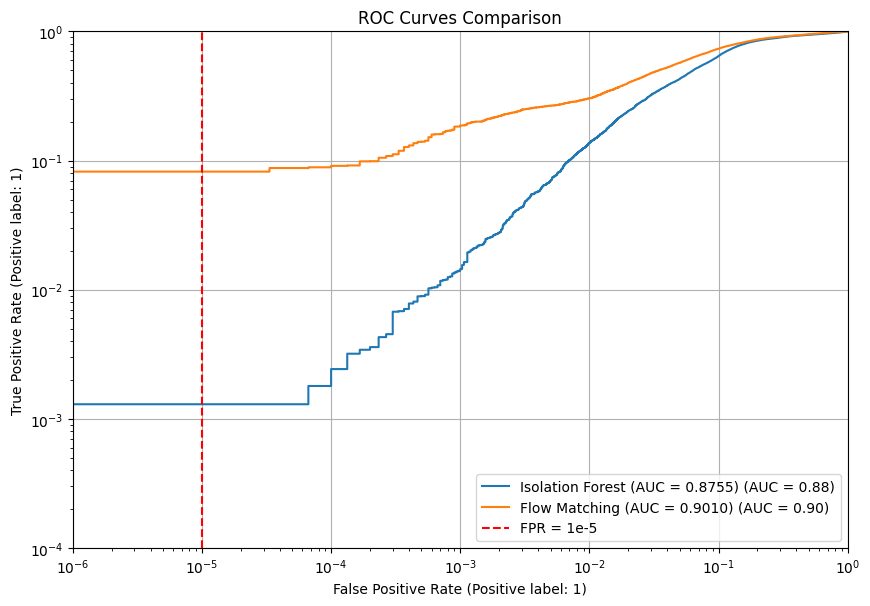

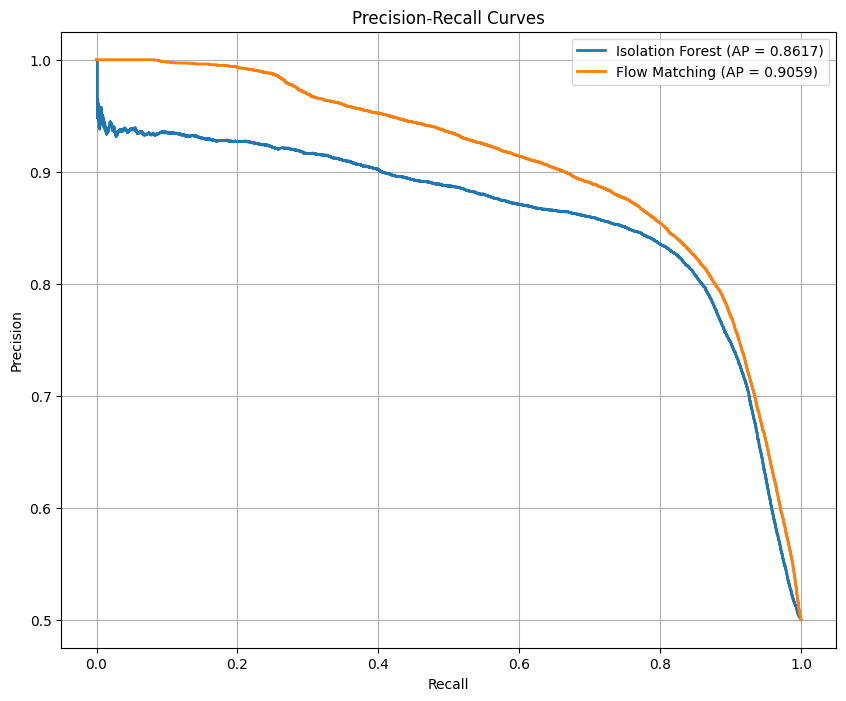

In [56]:
# Compare ROC curves
plt.figure(figsize=(10, 8))
from sklearn.metrics import RocCurveDisplay

for name, result in results.items():
    RocCurveDisplay.from_predictions(
        dataset.test_labels, 
        result['scores'],
        name=f"{name} (AUC = {result['auc']:.4f})",
        ax=plt.gca()
    )

plt.axvline(x=1e-5, color='red', linestyle='--', label='FPR = 1e-5')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-6, 1])
plt.ylim([1e-4, 1])
plt.title('ROC Curves Comparison')
plt.grid(True)
plt.legend()
plt.show()

# Compare Precision-Recall curves
plt.figure(figsize=(10, 8))
for name, result in results.items():
    precision, recall, _ = precision_recall_curve(dataset.test_labels, result['scores'])
    plt.plot(recall, precision, lw=2, 
             label=f"{name} (AP = {result['ap']:.4f})")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True)
plt.show()

## 6. Score Distributions

mean score for normal samples: 76.41636657714844
mean score for anomalous samples: 347.18505859375


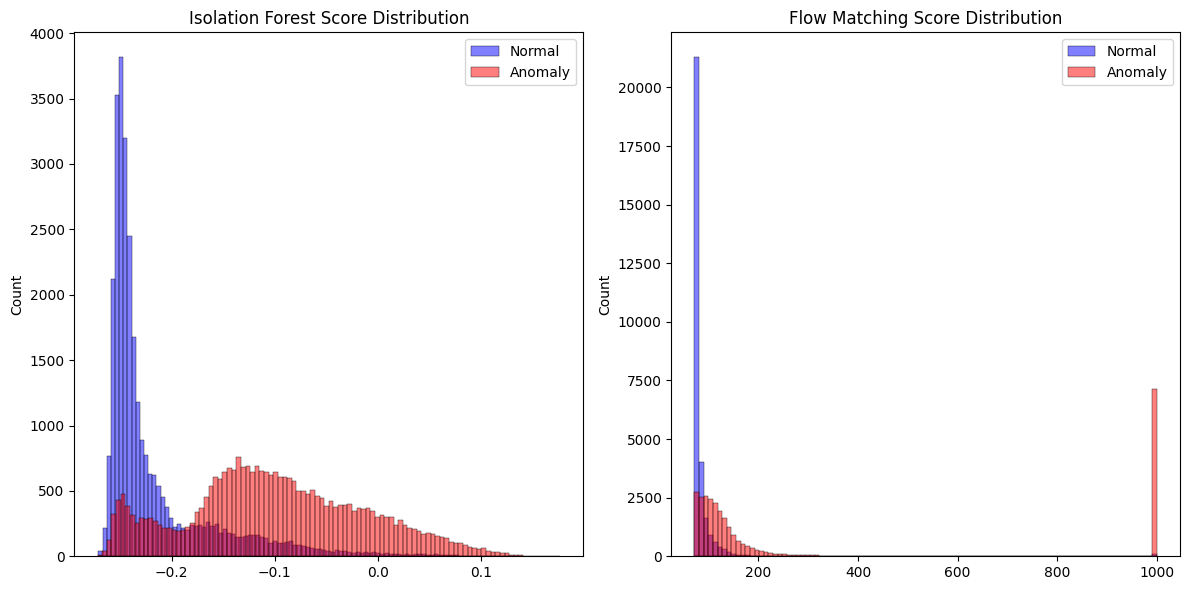

In [54]:
# Visualize anomaly scores distribution
plt.figure(figsize=(12, 6))

for i, (name, result) in enumerate(results.items(), 1):
    plt.subplot(1, len(results), i)
    
    # Separate scores for normal and anomaly classes
    normal_scores = result['scores'][dataset.test_labels == 0]
    anomaly_scores = result['scores'][dataset.test_labels == 1]
    
    if any(anomaly_scores > 1000):
        anomaly_scores[anomaly_scores > 1000] = 1000
        normal_scores[normal_scores > 1000] = 1000
        print(f"mean score for normal samples: {np.median(normal_scores)}")
        print(f"mean score for anomalous samples: {np.mean(anomaly_scores)}")
    # Plot histograms
    sns.histplot(normal_scores, color='blue', alpha=0.5, label='Normal', bins=100)  
    sns.histplot(anomaly_scores, color='red', alpha=0.5, label='Anomaly', bins=100)
    
    plt.title(f"{name} Score Distribution")
    plt.legend()

plt.tight_layout()
plt.show()

## 7. Results Summary

In [ ]:
# Create a summary table
print("==== Summary of Results ====")
print(f"{'Model':<20} {'AUC-ROC':<10} {'Avg Precision':<15} {'Training Time (s)':<15}")
print("-" * 60)
for name, result in results.items():
    print(f"{name:<20} {result['auc']:<10.4f} {result['ap']:<15.4f} {result['time']:<15.2f}")